<font size="+3"><strong>4.5. Earthquake Damage in Kavrepalanchok 🇳🇵</strong></font>

In this assignment, you'll build a classification model to predict building damage for the district of [Kavrepalanchok](https://en.wikipedia.org/wiki/Kavrepalanchok_District).

In [96]:
import warnings
import sqlite3
import numpy as np
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted
warnings.simplefilter(action="ignore", category=FutureWarning)

In [97]:
# Import libraries here


# Prepare Data

## Connect

Run the cell below to connect to the `nepal.sqlite` database.<span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

In [98]:
%load_ext sql
%sql sqlite:///../nepal.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<div class="alert alert-block alert-warning">
<b>Warning:</b>Be careful with your SQL queries in this assignment. If you try to get all the rows from a table (for example, <code>SELECT * FROM id_map</code>), you will cause an Out of Memory error on your virtual machine. So always include a <code>LIMIT</code> when first exploring a database.
</div>

**Task 4.5.1**

> Write your query in the input box in the left panel.

What's the district ID for Kavrepalanchok? From the lessons, you already know that Gorkha is `4`; from the textbook, you know that Ramechhap is `2`. Of the remaining districts, Kavrepalanchok is the one with the largest number of observations in the `id_map` table.

**Task 4.5.2** 

> Write your query in the input box in the left panel.

**Task 4.5.3** 

> Write your query in the input box in the left panel.

**Task 4.5.4** 

> Write your query in the input box in the left panel.

## Import

**Task 4.5.5** 

In [99]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 3
    """

   # Read query results into DataFrame
    df =pd.read_sql(query,conn,index_col="b_id")
    #to find leaky columns
    drop_cols=[i for i in df.columns if "post_eq" in i]
    
    #create binary target 
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"]=(df["damage_grade"]>3).astype(int)
    #drop column
    drop_cols.append("damage_grade")
    #remove multiclinearity
    drop_cols.append("count_floors_pre_eq")
    drop_cols.append("building_id")
    df.drop(columns=drop_cols,inplace=True)
    
    
    return df
    


Use your `wrangle` function to query the database at `"../nepal.sqlite"` and return  your cleaned results.

In [100]:
df =wrangle("../nepal.sqlite")
print(df["severe_damage"].value_counts())


1    41994
0    34539
Name: severe_damage, dtype: int64


## Explore

<div class="alert alert-info" role="alert">
  <strong>Slight Code Change</strong>

In the following task, you'll notice a small change in how plots are created compared to what you saw in the lessons.
While the lessons use the global matplotlib method like <code>plt.plot(...)</code>, in this task, you are expected to use the object-oriented (OOP) API instead.
This means creating your plots using <code>fig, ax = plt.subplots()</code> and then calling plotting methods on the <code>ax</code> object, such as <code>ax.plot(...)</code>, <code>ax.hist(...)</code>, or <code>ax.scatter(...)</code>.

If you're using pandas’ or seaborn’s built-in plotting methods (like <code>df.plot()</code> or <code>sns.lineplot()</code>), make sure to pass the <code>ax=ax</code> argument so that the plot is rendered on the correct axes.

This approach is considered best practice and will be used consistently across all graded tasks that involve matplotlib.
</div>


**Task 4.5.6** 

In [101]:
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
superstructure            11
dtype: int64

In [102]:
df["severe_damage"].corr(df["height_ft_pre_eq"])

-0.15804371718380736

In [103]:
df["severe_damage"].corr(df["count_floors_pre_eq"])

KeyError: 'count_floors_pre_eq'

In [ ]:
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()
# Plot heatmap of `correlation`

sns.heatmap(correlation)


In [ ]:
fig, ax = plt.subplots() 

# Calculate value counts and plot on the axes object
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar",
    ax=ax  # Direct the plot to our Axes object
)

# Set labels and title 
ax.set_xlabel("Severe Damage")
ax.set_ylabel("Relative Frequency")
ax.set_title("Kavrepalanchok, Class Balance");

**Task 4.5.7** 

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots() 

# Create the Seaborn boxplot 
sns.boxplot(data=df, x="severe_damage", y="plinth_area_sq_ft", ax=ax)

# Set labels and title
ax.set_xlabel("Severe Damage")
ax.set_ylabel("Plinth Area [sq. ft.]")
ax.set_title("Kavrepalanchok, Plinth Area vs Building Damage");

**Task 4.5.8** 

In [ ]:
roof_pivot =pd.pivot_table(df,index="roof_type",values="severe_damage",aggfunc=np.mean).sort_values(by="severe_damage")
roof_pivot

## Split

**Task 4.5.9** 

In [ ]:
target = "severe_damage"
X = df.drop(columns=[target])
y =df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

**Task 4.5.10** 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Build Model

## Baseline

**Task 4.5.11** 

In [ ]:
acc_baseline = df["severe_damage"].value_counts(normalize=True).max()

print("Baseline Accuracy:", round(acc_baseline, 2))

## Iterate

**Task 4.5.12** 

In [ ]:


model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=3000)
)
model_lr.fit(X_train,y_train)



**Task 4.5.13** 

In [ ]:
lr_train_acc =accuracy_score(y_train,model_lr.predict(X_train))
lr_val_acc =model_lr.score(X_val,y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

**Task 4.5.14** 

In [ ]:

epth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d,random_state=42)
    )
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train, y_train))
    validation_acc.append(model_dt.score(X_val, y_val))

In [ ]:
# Run this cell
submission = pd.Series(validation_acc, index=depth_hyperparams)
submission

**Task 4.5.15**

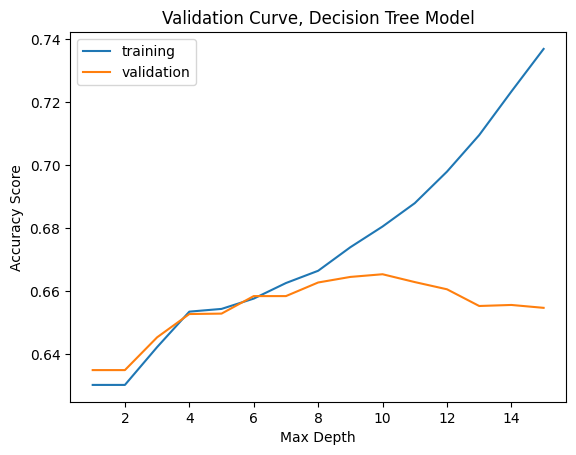

In [104]:
fig, ax = plt.subplots() 

#  Plot the training accuracy on the axes object
ax.plot(depth_hyperparams, training_acc, label="training")

#  Plot the validation accuracy on the same axes object
ax.plot(depth_hyperparams, validation_acc, label="validation") 

#  Set labels and title  
ax.set_xlabel("Max Depth")
ax.set_ylabel("Accuracy Score")
ax.set_title("Validation Curve, Decision Tree Model")

# Add the legend 
ax.legend()

**Task 4.5.16** 

In [111]:
final_model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=10, random_state=42)
)

final_model_dt.fit(X, y)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Adobe/mud                2
Brick, cement mortar     3
Brick, mud mortar        4
RC, non-engineered       5
Timber                   6
Bamboo                   7
Stone, cement mortar     8
RC, engineered           9
Other                   10
Stone                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

## Evaluate

**Task 4.5.17** 

In [ ]:
X_train.columns

In [113]:
# Step 1: Read the test set
X_test = pd.read_csv("data/kavrepalanchok-test-features.csv", index_col="b_id")



# Step 3: Generate test predictions
y_test_pred = final_model_dt.predict(X_test)


y_test_pred[:5]


array([1, 1, 0, 1, 0])

# Communicate Results

**Task 4.5.18** 

In [122]:
feature=X.columns
importance=final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_
feat_imp=pd.Series(importance,index=feature).sort_values()
feat_imp.head()

plan_configuration        0.004032
position                  0.007129
land_surface_condition    0.008241
ground_floor_type         0.009741
foundation_type           0.010620
dtype: float64

**Task 4.5.19** 

Do you see any relationship between this plot and the exploratory data analysis you did regarding roof type?

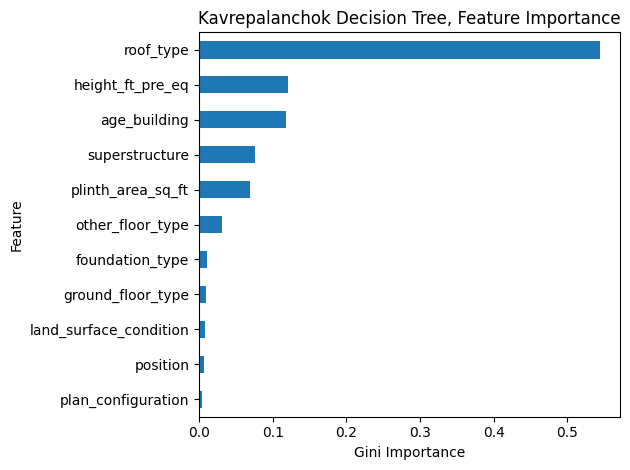

In [125]:
fig, ax = plt.subplots() 

# Create the horizontal bar plot on the axes object
feat_imp.plot(kind="barh", ax=ax)

# Set labels and title 
ax.set_xlabel("Gini Importance")
ax.set_ylabel("Feature")
ax.set_title("Kavrepalanchok Decision Tree, Feature Importance")

# Apply tight layout 
fig.tight_layout()

Congratulations! You made it to the end of Project 4. 👏👏👏

---
Copyright 2023 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
